# Text Classification using Naive-Bayes
### Gregorio Mendoza Serrano

# Introduction

In this exercise, we are going to examine a dataset containing information about scientific texts on three types of cancer, with the goal of classifying a scientific text according to the type of cancer it addresses. The file **cancertext.csv** that we will use includes two columns, one with the type of cancer and another with the corresponding scientific article on the subject.

This analysis will allow us to apply and delve into Machine Learning techniques, such as the Naive-Bayes classification method, as well as feature extraction procedures, essential for preparing and optimizing the data for modeling.

We will begin with data exploration to understand its structure and observe how balanced our dataset is. Then, we will prepare the data for analysis by applying feature extraction techniques to enable the desired model application. Subsequently, we will define, train, and evaluate the model.

The dataset we will be working with is used for text classification in biomedicine. It contains thousands of research articles published on three types of cancer: thyroid cancer, colon cancer, and lung cancer. When loading the dataset with pandas, you must include the parameter ***encoding="latin-1"*** for proper text decoding.

## 1 Import of Libraries


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

from sklearn import metrics

## 2 Exploratory Data Analysis (EDA)

**Exercise 1** - Carry out an EDA procedure to obtain information about the data and detail the problem to be modeled:

* Declare the size of the dataset and display some records on screen. Rename the variables in our dataset to "Tipo_Cancer" and "Texto_Cientifico".

* What is our target variable? Analyze the distribution (using graphical methods) and reason whether the dataset is well-balanced and how this will affect classification. Argue whether it is necessary to select prior distributions to balance our data in the problem to be modeled.



In [ ]:
# Cargar el conjunto de datos asignando nombres a las columnas
column_names = ['Tipo_Cancer', 'Texto_Cientifico']
df = pd.read_csv('cancertext.csv', encoding='latin-1',
                 names=column_names, header=None, skiprows=1)

# Mostrar el tamaño del dataset
print("Tamaño del Dataset:", df.shape)

# Mostrar algunos registros por pantalla
df.head()

Tamaño del Dataset: (7570, 2)


,Tipo_Cancer,Texto_Cientifico
0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,Thyroid_Cancer,This study aimed to investigate serum matrix ...


Our target variable is `'Tipo_Cancer'`, as we want to predict the type of cancer discussed in an unseen text by the algorithm.

We will draw a histogram of the classes in the dataset (types of cancer) and calculate the proportions of each class:

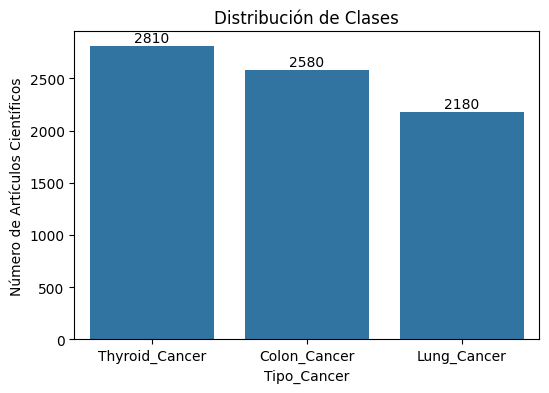



Proporción de cada clase:
Thyroid_Cancer    0.37
Colon_Cancer      0.34
Lung_Cancer       0.29
Name: Tipo_Cancer, dtype: float64


In [ ]:
# Visualizar la distribución de clases:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='Tipo_Cancer', data=df,
                   order=df['Tipo_Cancer'].value_counts().index)

# Mostrar el valor de count en cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height().astype(int)}',
     (p.get_x() + p.get_width() / 2., p.get_height() + 5),
                ha='center', va='bottom')

#plt.ylim(0, 2250)
plt.title('Distribución de Clases')
plt.ylabel('Número de Artículos Científicos')
plt.show()
print("\n")

# Calcular la proporción de cada clase
class_proportions = df['Tipo_Cancer'].value_counts(normalize=True)

# Mostrar la proporción de cada clase
print("Proporción de cada clase:")
print(class_proportions.round(2))

In light of the results, we can say that the sample is unbalanced, though not excessively (there is a 12% difference between the most common and the least common class).

In [ ]:
# Variable objetivo
target_variable = 'Tipo_Cancer'

# Análisis de balance del dataset
class_distribution = df[target_variable].value_counts()
print("\nDistribución de clases:")
print(class_distribution)

# Proporción de clases en porcentaje
class_percentage = (class_distribution / len(df) * 100).round(1)
print("\nProporción de clases (%):")
print(class_percentage)

# Análisis y argumentación sobre el balance de clases
if len(class_distribution) > 1:
    imbalance_ratio = class_percentage.max() / class_percentage.min()
    print(f"\nRatio de desbalance: {imbalance_ratio:.2f}")


Distribución de clases:
Thyroid_Cancer    2810
Colon_Cancer      2580
Lung_Cancer       2180
Name: Tipo_Cancer, dtype: int64

Proporción de clases (%):
Thyroid_Cancer    37.1
Colon_Cancer      34.1
Lung_Cancer       28.8
Name: Tipo_Cancer, dtype: float64

Ratio de desbalance: 1.29


An imbalance ratio of approximately 1.3 is generally not considered critical and can be managed with standard classification approaches.

## 3 Feature Extraction

**Exercise 2** - We will perform transformations on our raw data to obtain the variables needed to model the problem correctly:

* Transform the target variable from text to numerical encoding using the `LabelEncoder` method from the SKLearn library (documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)).
* **Dataset Split**: Segment the data using the scikit-learn library, allocating 75% for the training set and 25% for the test set. Indicate the size of both sets.
* **Feature Extraction**: Use the `CountVectorizer` method for feature extraction in our model and explain how this method works.


Next, we encode our target variable using `LabelEncoder()` as required in the prompt. After that, we split the dataset into training and testing sets using `train_test_split()`, and finally, we extract features using `CountVectorizer()`.

The `CountVectorizer()` method tokenizes each of the texts in our 'Texto_Cientifico' column and creates a matrix where, for each row (corresponding to a text), we have a count of occurrences of each specific word in each column. In this way, our dataset can be processed using the Naive-Bayes method.

In [ ]:
# 1. Transformación de la variable objetivo a codificación numérica
label_encoder = LabelEncoder()
df['Tipo_Cancer_Encoded'] = label_encoder.fit_transform(df['Tipo_Cancer'])

# Crear un diccionario que contiene la relación entre etiquetas antes y después del encoder
label_mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))

# Crear un DataFrame a partir del diccionario label_encoder
df_label_mapping = pd.DataFrame(list(label_mapping.items()), columns=['Label', 'Clase']).set_index('Label')

# Mostramos el DataFrame:
df_label_mapping

,Clase
Label,
0,Colon_Cancer
1,Lung_Cancer
2,Thyroid_Cancer


Entrenamos el modelo:

In [ ]:

# 2. División del conjunto de datos en entrenamiento y prueba
X = df['Texto_Cientifico']
y = df['Tipo_Cancer_Encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de prueba: {len(X_test)}")

# 3. Extracción de características con CountVectorizer
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)


Tamaño del conjunto de entrenamiento: 5677
Tamaño del conjunto de prueba: 1893


## 4 Model Training

**Exercise 3**: Once the features have been extracted, we need to construct and train the desired model:

* Reasonably argue which **Naive-Bayes model** to apply in this case based on the distribution of the features.

* **Training**: Train the selected model using the training set with the chosen Naive-Bayes algorithm. Use the Laplace smoothing coefficient with a value of *alpha = 2*. Explain in detail what this coefficient's function is and what value it brings to the model.

* Construct the **model in two different ways**: First, by applying the transformation using the *CountVectorizer* function on our training data, and then using the Pipeline method from SkLearn.

Since this is a problem involving word counts in texts, the features would be the number of times each word appears in each message, meaning they are discrete variables.

Consequently, we will apply the **Multinomial Naive-Bayes** model, as it assumes a multinomial distribution, which is suitable for discrete data like counts.

**Laplace smoothing** is used to avoid "zero frequency" problems and involves adding a small number to all attributes. In this case, the set value is *alpha = 2*, which represents a relatively strong smoothing effect. A low *alpha* value could result in overfitting the model if there were few training data points.

The model will be trained using both `CountVectorizer()` and `Pipeline()`, and then evaluated for both cases.

In [ ]:
# Aplicar CountVectorizer
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Construir y entrenar el modelo de Naive Bayes
modelv = MultinomialNB()
modelv.fit(X_train_vectorized, y_train)

# Predecir en el conjunto de prueba
y_pred = modelv.predict(X_test_vectorized)

# Evaluar el rendimiento del modelo
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.93


In [ ]:
# Construir y entrenar el modelo utilizando Pipeline
model = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])

# Entrenar el modelo
model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el rendimiento del modelo
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.93


The test accuracy of the model using both `Pipeline()` and `CountVectorizer()` is the same (93%), which confirms that both methods have been implemented correctly.

## 5 Model Evaluation

**Exercise 4**: Evaluating the performance of the model is key to understanding its effectiveness. It includes:

<font color='IndianRed'>*Responses are provided interspersed with the prompt, as well as in the results of the following code blocks:*</font>

* **Comparison of Metrics**: Observe and analyze performance metrics discussed in class, such as accuracy, precision, recall, and F1-score. What conclusions can be drawn from each of these metrics? Justify the responses reasonably.
  - **Accuracy:** It is the total proportion of correct vs. incorrect predictions, giving a general idea of the model's performance regarding the feature of interest.
  - **Recall (Sensitivity):** The proportion of actual positive samples that were correctly classified by the model. *In our case, this indicates how many texts of a specific type of cancer were correctly identified as such.*  
  - **Precision:** The proportion of samples classified as positive by the model that are truly positive. *In our case, this tells us how many of the model's predictions regarding texts of a specific type of cancer are actually of that type.*  
  - **F1-score:** A metric that combines precision and sensitivity into a single number. It is useful when there is an imbalance in classes. *This metric is not very relevant in our case.*  

* **Confusion Matrix**: Calculate the confusion matrix of the model and analyze the displayed results. What do each of the values correspond to? In the problem we are modeling, how many records have been predicted correctly and incorrectly for each class? Are we interested in a model with higher precision or higher sensitivity? Justify your answer reasonably.
  - The values on the diagonal correspond to correct predictions for each class.
  - The off-diagonal values correspond to incorrect predictions, with the columns representing true labels and the rows representing predicted labels. It can be observed that the model only confuses articles about Thyroid Cancer with Lung Cancer and vice versa.
  - In our case, **we are interested in a model with higher Recall**: If we are looking for articles about a specific type of cancer, it is preferable for the algorithm to make some mistakes and return documents of other types of cancer (which we would simply discard) than to miss identifying those that actually are (which would negatively impact our research).
  - The counts of incorrectly predicted records are detailed below in the code results.

* **Model Test Texts**: Manually generate 3 short test texts (one sentence long and in English) to test the model and classify them.

  - *See below. The algorithm is correct in all three cases. The expected classes are detailed in comments in the code.*

* **Conclusions**: Based on all the observed metrics, how could we improve the model in future iterations? What factors or features are we interested in regarding the text classification problem? From a Bayesian perspective, would it be interesting to include prior and/or subjective information by selecting a specific prior distribution?

  - *The only confusion of the model occurs between the classes 'Thyroid_Cancer' and 'Colon_Cancer', which may imply that they are not as independent of each other as the class 'Lung_Cancer' is from the others.*

  - *The features of interest are those with the highest likelihood for each class. Since there is a very high number of words present across all classes (adverbs, pronouns, etc.), this can affect the final posterior prediction value.*
  
  - *A possible solution would be to remove words with a very high prior probability for all three classes.*

  - *Additionally, it may be a good idea to introduce a "negative class": literary texts with no relation to the classes we aim to detect, to help discriminate words unrelated to the scientific articles being classified.*

  - *Another option is to include extra entries in each class, artificially created, which are a list of expected terms for each type of text. This way, we would be increasing the prior probability of these words and enhancing the final prediction accuracy.*

  - *The only confusion of the model occurs between the classes 'Thyroid_Cancer' and 'Colon_Cancer', which may imply that they are not as independent of each other as the class 'Lung_Cancer' is from the others.*

Let's proceed to calculate the confusion matrix for both models and the associated metrics:

In [ ]:
# Evaluar el rendimiento del modelo
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Mostrar la matriz de confusión:
print("Confusion Matrix:")
print()
print(conf_matrix)


# Detalles sobre tipos de errores
false_positives = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
false_negatives = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
true_positives = np.diag(conf_matrix)
true_negatives = conf_matrix.sum() - (false_positives + false_negatives + true_positives)

# Calcular sensibilidad y precisión para cada clase
sensitivity = true_positives / (true_positives + false_negatives)
precision = true_positives / (true_positives + false_positives)

print("\nDetalles sobre tipos de errores:")
print()
for i in range(len(conf_matrix)):
    print(f"Clase {i}: {df_label_mapping.iloc[predictions[i],0]}")
    print(f"Falsos Positivos: {false_positives[i]}")
    print(f"Falsos Negativos: {false_negatives[i]}")
    print(f"Verdaderos Positivos: {true_positives[i]}")
    print(f"Verdaderos Negativos: {true_negatives[i]}")
    print(f"Sensibilidad (Recall): {sensitivity[i]:.4f}")
    print(f"Precisión: {precision[i]:.4f}")
    print()

# Mostramos el informe de clasificación:
print("\nClassification Report:")
print()
print(class_report)


Confusion Matrix:

[[587   0  56]
 [  0 526   0]
 [ 79   0 645]]

Detalles sobre tipos de errores:

Clase 0: Thyroid_Cancer
Falsos Positivos: 79
Falsos Negativos: 56
Verdaderos Positivos: 587
Verdaderos Negativos: 1171
Sensibilidad (Recall): 0.9129
Precisión: 0.8814

Clase 1: Colon_Cancer
Falsos Positivos: 0
Falsos Negativos: 0
Verdaderos Positivos: 526
Verdaderos Negativos: 1367
Sensibilidad (Recall): 1.0000
Precisión: 1.0000

Clase 2: Lung_Cancer
Falsos Positivos: 56
Falsos Negativos: 79
Verdaderos Positivos: 645
Verdaderos Negativos: 1113
Sensibilidad (Recall): 0.8909
Precisión: 0.9201


Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.91      0.90       643
           1       1.00      1.00      1.00       526
           2       0.92      0.89      0.91       724

    accuracy                           0.93      1893
   macro avg       0.93      0.93      0.93      1893
weighted avg       0.93      0.93      0.93      189

Let's now perform the prediction of three random small texts:

In [ ]:
# Example of one-sentence texts in English from three scientific articles on cancer
test_texts = [
    "Usually, only nodules measuring >1 cm are evaluated, unless there are other risk factors that increase the suspicion for malignancy",
    # Expected class: Tyroid_Cancer
    "The signs or symptoms are abdominal pain, rectal bleeding, diarrhea, and iron deficiency anemia.",
    # Expected class: Colon_Cancer
    "Its incidence and mortality patterns are consistently associated with 20 or more years of smoking history"
    # Expected class: Lung_Cancer
]

# Perform predictions on the test examples
predictions = model.predict(test_texts)

# Display the predictions for the test texts
for i, text in enumerate(test_texts):
    print(f"\nText {i+1}: {text}")
    print(f"Prediction: {df_label_mapping.iloc[predictions[i],0]}")


Texto 1: Usually, only nodules measuring >1 cm are evaluated, unless there are other risk factors that increase the suspicion for malignancy
Predicción: Thyroid_Cancer

Texto 2: The signs or symptoms are abdominal pain, rectal bleeding, diarrhea, and iron deficiency anemia.
Predicción: Colon_Cancer

Texto 3: Its incidence and mortality patterns are consistently associated with 20 or more years of smoking history
Predicción: Lung_Cancer
